# Spectral Normalized Gaussian Process (SNGP) Regression

In [74]:
import torch
import os
from functools import partial
from torch.optim import Adam
from lightning_uq_box.uq_methods import SNGPRegression
from lightning_uq_box.datamodules import ToyDUE, ToyHeteroscedasticDatamodule
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.viz_utils import (
    plot_toy_regression_data,
    plot_predictions_regression,
    plot_training_metrics,
)

import tempfile

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

seed_everything(42)

Seed set to 42


42

## Datamodule

In [96]:
datamodule = ToyDUE(batch_size=128, n_samples=1000)
datamodule.__dict__.keys()
X_train, y_train, X_test, y_test, train_loader, test_loader = (
    datamodule.X_train,
    datamodule.y_train,
    datamodule.X_test,
    datamodule.y_test,
    datamodule.train_dataloader(),
    datamodule.val_dataloader(),
)

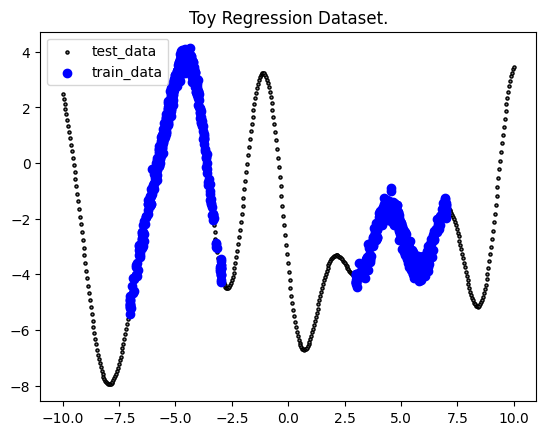

In [97]:
fig = plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

In [98]:
feature_extractor = FCResNet(input_dim=1, features=128, depth=4)
feature_extractor

FCResNet(
  (first): Linear(in_features=1, out_features=128, bias=True)
  (residuals): ModuleList(
    (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.01, inplace=False)
)

In [99]:
sngp = SNGPRegression(
    feature_extractor=feature_extractor,
    loss_fn=torch.nn.MSELoss(),
    optimizer=partial(Adam, lr=1e-3),
)
sngp

SNGPRegression(
  (feature_extractor): FCResNet(
    (first): Linear(in_features=1, out_features=128, bias=True)
    (residuals): ModuleList(
      (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (loss_fn): MSELoss()
  (normalize): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (rff): RandomFourierFeatures()
  (beta): Linear(in_features=1024, out_features=1, bias=True)
  (train_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (R2): R2Score()
    (RMSE): MeanSquaredError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (R2): R2Score()
    (RMSE): MeanSquaredError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MAE): MeanAbsoluteError()
    (R2): R2Score()
    (RMSE): MeanSquaredError(),
    prefix=test
  )
)

## Trainer

In [100]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [101]:
trainer.fit(sngp, datamodule)


  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | FCResNet              | 66.3 K
1 | loss_fn           | MSELoss               | 0     
2 | normalize         | LayerNorm             | 256   
3 | rff               | RandomFourierFeatures | 0     
4 | beta              | Linear                | 1.0 K 
5 | train_metrics     | MetricCollection      | 0     
6 | val_metrics       | MetricCollection      | 0     
7 | test_metrics      | MetricCollection      | 0     
------------------------------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.270     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

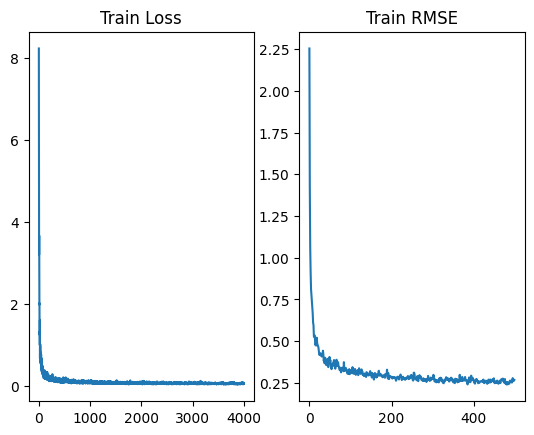

In [102]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Prediction

In [103]:
preds = sngp.predict_step(X_test)

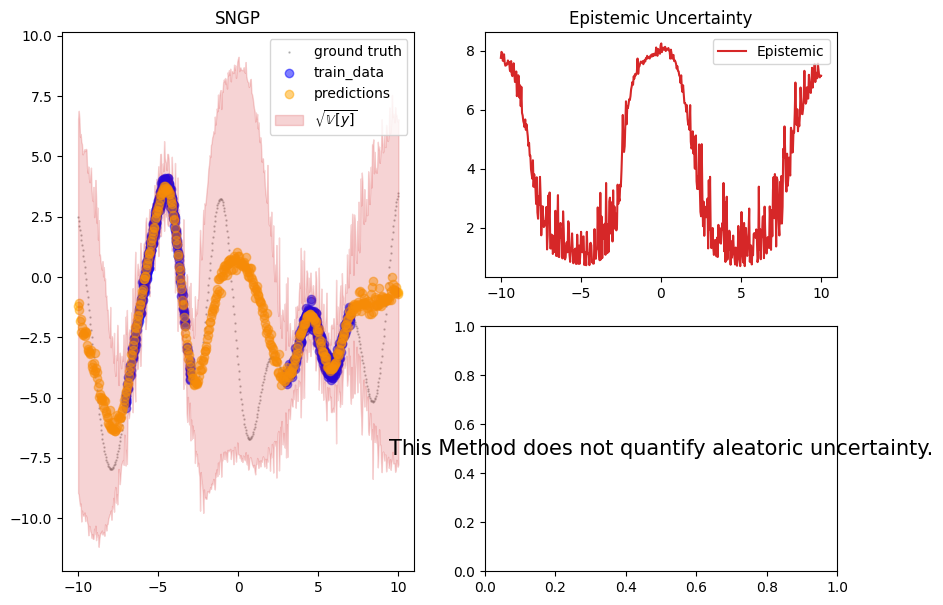

In [104]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="SNGP",
    show_bands=False,
)